**Description**: Simulation for [my answer on
stackoverflow.com](https://stackoverflow.com/a/76230531/18758987) that there's an
efficient way to sample from log-probabilities or unnnormalized logits.

**Estimated runtime**: 20 sec.

**TODO**: does precomputing the Gumbels result in dependence b/t draws? Methinks yes.
But if not, then there's a way to speed up the existing [LM sampling logic](https://github.com/huggingface/transformers/blob/dee673232bdc300ced32f7c1c4cd0b9447b1478f/src/transformers/generation/utils.py#L2646-L2648).

**Package requirements**:
```
matplotlib==3.4.3
pandas==1.3.4
scipy==1.7.1
```

In [1]:
from __future__ import annotations
from time import time
from typing import Union, Sequence

import numpy as np
import pandas as pd
from scipy.special import logsumexp, softmax
from scipy.stats import chisquare, trim_mean

## Implementation

In [2]:
def random_choice_log_space(
    logits: np.ndarray,
    size: int = 1,
    gumbels: np.ndarray = None,
    shuffle_gumbels: bool = True,
    rng: Union[np.random.Generator, int] = None,
) -> np.ndarray:
    """
    Sample (with replacement) from a categorical distribution parametrized by logits or
    log-probabilities.

    Parameters
    ----------
    logits : np.ndarray
        the last dimension contains log-probabilities (e.g., out of a log-softmax
        function) or unnormalized logits corresponding to the categorical
        distribution(s)
    size : int, optional
        sample size, by default 1
    gumbels : np.ndarray, optional
        (experimental feature) pre-computed Gumbel samples which will be added to
        `logits`, by default None
    shuffle_gumbels : bool, optional
        (experimental feature) whether or not to shuffle `gumbels` (if provided) before
        taking the argmax, by default True
    rng : Union[np.random.Generator, int], optional
        ``np.random.Generator`` object or an integer seed, by default None

    Returns
    -------
    np.ndarray
        sampled indexes

    Raises
    ------
    ValueError
        if `size` is negative
    """
    if size < 1:
        raise ValueError("size must be at least 1.")
    is_gumbels_precomputed = gumbels is not None
    # Create a Generator if needed
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)
    if not is_gumbels_precomputed:
        # Independently sample as many Gumbels as needed. During addition, they'll be
        # broadcasted
        _gumbels_shape = (size,) + logits.shape if size > 1 else logits.shape
        gumbels: np.ndarray = rng.gumbel(size=_gumbels_shape)
    if is_gumbels_precomputed and shuffle_gumbels:
        # Shuffling is unnecessary if the Gumbels were just randomly sampled
        gumbels = rng.permutation(gumbels, axis=0)
    gumbels_rescaled: np.ndarray = logits + gumbels
    return gumbels_rescaled.argmax(axis=-1)

## Statistical check

In [3]:
_probs = np.array([0.1, 0.2, 0.3, 0.4])

log_probs = np.log(_probs)
logits = np.log(_probs) + logsumexp(_probs, axis=-1)
# You start out with access to log_probs or logits

num_categories = len(_probs)

sample_size = 500_000
seed = 123
rng = np.random.default_rng(seed)


# helper function
def empirical_distr(discrete_samples):
    return (pd.Series(discrete_samples)
            .value_counts(normalize=True)
            .sort_index()
            .to_numpy())


# np.random.choice (select one at a time) AKA vanilla sampling
def random_choice_log_space_vanilla(logits, size, rng=None):
    probs = softmax(logits, axis=-1)
    if not isinstance(rng, np.random.Generator):
        rng = np.random.default_rng(seed=rng)
    return rng.choice(len(probs), p=probs, size=size, replace=True)


samples = random_choice_log_space_vanilla(logits, size=sample_size, rng=rng)
distr_vanilla = empirical_distr(samples)


# random_choice_log_space for log-probabilities input
samples = random_choice_log_space(log_probs, size=sample_size, rng=rng)
distr_log_probs = empirical_distr(samples)


# random_choice_log_space for logits input
samples = random_choice_log_space(logits, size=sample_size, rng=rng)
distr_logits = empirical_distr(samples)

In [4]:
pd.DataFrame({'rel error (vanilla)': (distr_vanilla - _probs)/_probs,
              'rel error (log-probs)': (distr_log_probs - _probs)/_probs,
              'rel error (logits)': (distr_logits - _probs)/_probs},
              index=pd.Index(range(num_categories), name='category'))

## For copy-pasting:
# print(pd.DataFrame({'rel error (vanilla)': (distr_vanilla - _probs)/_probs,
#                     'rel error (log-probs)': (distr_log_probs - _probs)/_probs,
#                     'rel error (logits)': (distr_logits - _probs)/_probs},
#                     index=pd.Index(range(num_categories), name='category')))

,rel error (vanilla),rel error (log-probs),rel error (logits)
category,,,
0,-0.004760,0.006600,0.001760
1,0.000170,-0.004080,-0.000170
2,0.002773,0.001373,-0.000693
3,-0.000975,-0.000640,0.000165


Even at this super high sample size, the p-value for a [chi-squared
test](https://en.wikipedia.org/wiki/Chi-squared_test) is nearly 1 for all methods.

In [5]:
print(chisquare(f_obs=distr_vanilla,   f_exp=_probs).pvalue)
print(chisquare(f_obs=distr_log_probs, f_exp=_probs).pvalue)
print(chisquare(f_obs=distr_logits,    f_exp=_probs).pvalue)

0.999999997062783
0.9999999935077725
0.999999999914127


## Computational check

In [6]:
def time_func(func, *args, num_replications: int=50, **kwargs) -> list[float]:
    '''
    Returns a list, `times`, where `times[i]` is the time it took to run
    `func(*args, **kwargs)` at replication `i` for `i in range(num_replications)`.
    '''
    times = []
    for _ in range(num_replications):
        time_start = time()
        _ = func(*args, **kwargs)
        time_end = time()
        times.append(time_end - time_start)
    return times


def plot_sampling_times(category_sizes: Sequence[int], sample_size: int,
                        num_replications: int=100, precompute_gumbels: bool=False):
    times_vanilla = []
    times_gumbel = []
    for size in category_sizes:
        logits: np.ndarray = np.random.normal(size=size)
        gumbels = np.random.gumbel(size=logits.shape) if precompute_gumbels else None
        times_vanilla.append(time_func(random_choice_log_space_vanilla,
                                    logits,
                                    size=sample_size,
                                    num_replications=num_replications))
        times_gumbel.append(time_func(random_choice_log_space,
                                    logits,
                                    size=sample_size,
                                    gumbels=gumbels,
                                    num_replications=num_replications))
    (pd.DataFrame({'vanilla': trim_mean(times_vanilla, 0.1, axis=1),
                   'Gumbel': trim_mean(times_gumbel, 0.1, axis=1)},
                  index=pd.Index(category_sizes, name='# categories'))
     .plot.bar(title='Categorical sampling',
               figsize=(8,5),
               ylabel='mean wall-clock time (sec)'));

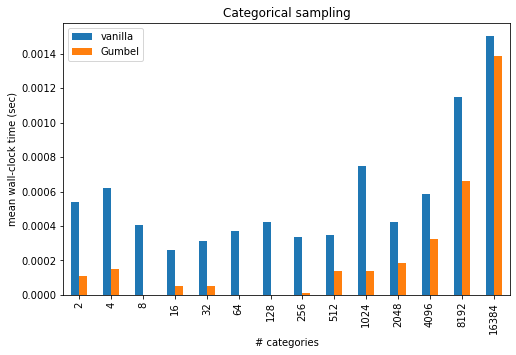

In [7]:
category_sizes = np.power(2, np.arange(1, 14+1))
sample_size = 1
num_replications = 100
precompute_gumbels = False

plot_sampling_times(category_sizes, sample_size, num_replications=num_replications,
                    precompute_gumbels=precompute_gumbels)

## Precompute and shuffle Gumbels

In [8]:
logits = np.random.normal(size=50_257)

In [9]:
%timeit random_choice_log_space_vanilla(logits, size=1)

2.39 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit random_choice_log_space(logits, size=1)

3.76 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
gumbels = np.random.gumbel(size=logits.shape)

In [12]:
%timeit random_choice_log_space(logits, size=1, gumbels=gumbels)

2.03 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
